In [1]:
import pandas as pd
import os
import json

pd.set_option('display.max_columns', None)


In [2]:
output_df= pd.read_pickle(f"data/altered_data/all_models_prediction_output.pkl")
eval_df = pd.read_pickle("data/eval/evaluation_metrics.pkl")
with open(f"data/definitions/icd_code_mapping.json", "r") as file:
    icd_code_mapping = json.load(file)
eval_df[["accuracy", "auc_score_weighted", "macroavg_precision", "macroavg_recall",	"macroavg_f1score",	"weightedavg_precision", "weightedavg_recall",	"weightedavg_f1score"]]


,accuracy,auc_score_weighted,macroavg_precision,macroavg_recall,macroavg_f1score,weightedavg_precision,weightedavg_recall,weightedavg_f1score
baseline_model,0.4348,0.744055,0.429666,0.434390,0.430376,0.430548,0.4348,0.430999
baseline_model_pca,0.3828,0.692056,0.379208,0.382563,0.380154,0.379811,0.3828,0.380562
b2_openai_vectorised_model,0.3988,0.709237,0.397547,0.398584,0.396913,0.397974,0.3988,0.397211
llm_model,0.3328,NaN,0.337158,0.332800,0.306469,0.337158,0.3328,0.306469


In [ ]:
orig_df = pd.read_pickle("data/altered_data/input_data.pkl")
orig_df["icd_code_encoded"] = orig_df["icd_code"].map(icd_code_mapping)

prepped_df = pd.read_pickle("data/altered_data/prepared_data.pkl").reset_index()
df = (prepped_df[[
    'subject_id', 'hadm_id','is_male', 'icd_code_encoded'
]]
    .merge(orig_df, on=["subject_id", "hadm_id", "icd_code_encoded"], how="left")
    .merge(
        output_df.reset_index().drop(["level_0", "index"], axis=1)
        , on=["subject_id", "hadm_id", "icd_code_encoded"], how="left"
        )
)
df["llm_predictive_reasoning"] = df.llm_predictive_reasoning.apply(lambda x: x[0] if len(x) <= 1 else x)

print(df.shape)

(12511, 35)


In [22]:
test = df.groupby(["subject_id", "hadm_id"])["icd_code"].nunique().reset_index(name="code_count")
len(test[test["code_count"] > 1]) / len(test)

0.04187171573942781

In [34]:
import numpy as np
df["llm_inaccurate_preds"] = np.where(df.icd_code_encoded != df.llm_predicted_icd_code_encoded, 1, 0)
text_cols = ["merged_labevents_text", "merged_microbiology_events", "merged_pharmacy_events"]
for col in text_cols:
    df[f"length_{col}"] = df[col].fillna("").apply(lambda x: len(x))

In [ ]:
df[df['llm_inaccurate_preds'] == 0][[
    'length_merged_labevents_text', 'length_merged_microbiology_events', 'length_merged_pharmacy_events'
]].describe().T


,count,mean,std,min,25%,50%,75%,max
length_merged_labevents_text,4163.0,267.641605,405.311496,0.0,66.0,147.0,312.0,6076.0
length_merged_microbiology_events,4163.0,5.517415,12.610754,0.0,0.0,0.0,5.0,206.0
length_merged_pharmacy_events,4163.0,48.754984,52.819468,0.0,20.0,33.0,58.0,901.0


In [49]:
df[df['llm_inaccurate_preds'] == 1].sample(10)["hadm_id"].unique()

array([22919017.0, 27856517.0, 21794773.0, 22874241.0, 27748832.0,
       24862472.0, 28012650.0, 26700729.0, 23866567.0, 28208159.0],
      dtype=object)

In [43]:
df[df['llm_inaccurate_preds'] == 1][[
    'length_merged_labevents_text', 'length_merged_microbiology_events', 'length_merged_pharmacy_events'
]].describe().T

,count,mean,std,min,25%,50%,75%,max
length_merged_labevents_text,8348.0,270.653690,490.855805,0.0,61.0,142.0,305.0,14984.0
length_merged_microbiology_events,8348.0,4.859487,11.996356,0.0,0.0,0.0,4.0,245.0
length_merged_pharmacy_events,8348.0,49.942980,54.227236,0.0,21.0,34.0,60.0,911.0


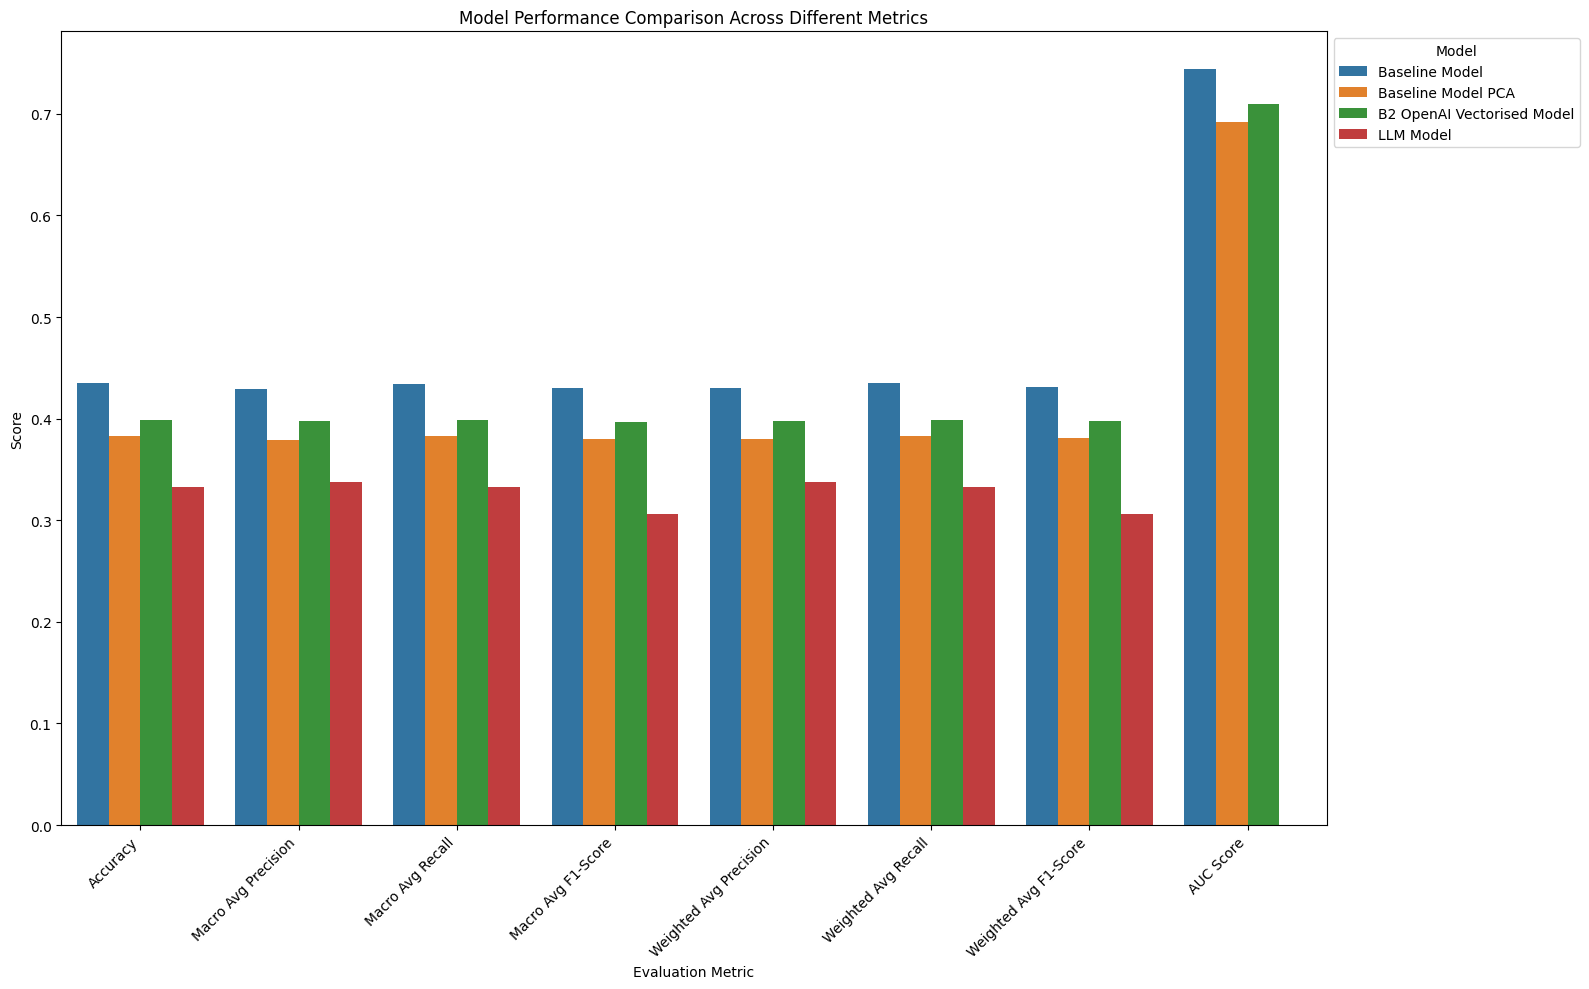

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Extract data from evaluation metrics
metrics_df = pd.DataFrame({
    'Model': ['Baseline Model', 'Baseline Model PCA', 'B2 OpenAI Vectorised Model', 'LLM Model'],
    'Accuracy': eval_df['accuracy'],
    'Macro Avg Precision': eval_df['macroavg_precision'],
    'Macro Avg Recall': eval_df['macroavg_recall'],
    'Macro Avg F1-Score': eval_df['macroavg_f1score'],
    'Weighted Avg Precision': eval_df['weightedavg_precision'],
    'Weighted Avg Recall': eval_df['weightedavg_recall'],
    'Weighted Avg F1-Score': eval_df['weightedavg_f1score'],
    'AUC Score': eval_df['auc_score_weighted']
})

# Set up the figure
plt.figure(figsize=(16, 10))

# Plotting the metrics comparison
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")

sns.barplot(x="Metric", y="Score", hue="Model", data=metrics_melted)
plt.xticks(rotation=45, ha='right')
plt.title("Model Performance Comparison Across Different Metrics")
plt.xlabel("Evaluation Metric")
plt.ylabel("Score")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Model")

# Display the plot
plt.tight_layout()
plt.show()


The bar chart above compares the four models' performance across various evaluation metrics:

Accuracy: The Baseline Model shows the highest accuracy at 43.48%, followed closely by the B2 OpenAI Vectorised Model and Baseline Model PCA. The LLM Model has the lowest accuracy at 33.28%.

Macro Average Precision, Recall, and F1-Score: These scores are highest for the Baseline Model across all metrics. The LLM Model consistently performs the lowest in these metrics, with the Baseline Model PCA and B2 OpenAI Vectorised Model showing intermediate performance.

Weighted Average Precision, Recall, and F1-Score: Similar trends are observed here, where the Baseline Model leads in performance, while the LLM Model underperforms. The B2 OpenAI Vectorised Model shows slightly better performance than the Baseline Model PCA.

AUC Score: This metric, not available for the LLM Model, shows the Baseline Model as the leader with 0.744, while the B2 OpenAI Vectorised Model and Baseline Model PCA trail behind with scores of 0.709 and 0.692, respectively.

In summary, the Baseline Model shows the best overall performance across all metrics, while the LLM Model has lower performance, particularly in accuracy and macro/weighted average scores. The B2 OpenAI Vectorised Model and Baseline Model PCA display middle-ground performance. This analysis helps demonstrate the trade-offs in performance between various models.